# Analysis of the forest fire dataset

Following  is the information of the features of the dataset.
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).



In [3]:
#importing the req libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot,axis,show,pcolor,colorbar,bone
%matplotlib inline
import numpy as np
import pandas as pd
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from minisom import MiniSom


In [6]:
#reading the dataset 

original_data = pd.read_csv('forestfires.csv')
print(original_data.shape)
original_data.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [9]:
# now for categorising the text attricutes month and day for homogenity 
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 
                 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 
                 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 
               'fri': 5, 'sat': 6, 'sun': 7 }
changed = original_data.replace({'month': month_mapping, 'day': day_mapping})
changed.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# step 1 :- preprocessing

### normalizing the dataset to remove the large variance of the values
#### and then transposing the matrix to make it more easily understandable and implementable in future analysis by doing the transpose

In [21]:
data_mean = data.mean(0)
centered_data = data - data_mean
centered_data.head()
data_std = centered_data.std(0)
std_data = centered_data/data_std
std_data.head(13)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1.007337,0.569309,-1.966538,0.357375,-0.805180,-1.322045,-1.828706,-0.860113,-1.840857,0.411326,1.497164,-0.073197,-0.201824
1,1.007337,-0.243765,1.109046,-1.089853,-0.008094,-1.178399,0.488418,-0.509195,-0.153130,-0.691786,-1.740070,-0.073197,-0.201824
2,1.007337,-0.243765,1.109046,0.839784,-0.008094,-1.048806,0.560173,-0.509195,-0.738668,-0.691786,-1.516813,-0.073197,-0.201824
3,1.439531,1.382383,-1.966538,0.357375,0.191177,-1.211188,-1.896429,-0.004751,-1.823636,3.230391,-0.009824,0.602572,-0.201824
4,1.439531,1.382383,-1.966538,1.322193,-0.243597,-0.930142,-1.796859,0.126843,-1.289763,3.352959,-1.237741,-0.073197,-0.201824
5,1.439531,1.382383,0.230308,1.322193,0.299871,-0.399278,-0.241629,1.245392,0.570182,-0.936922,0.771577,-0.073197,-0.201824
6,1.439531,1.382383,0.230308,-1.572262,0.299871,-0.343069,-0.210992,-0.114413,0.897394,-1.059490,-0.512154,-0.073197,-0.201824
7,1.439531,1.382383,0.230308,-1.572262,0.154946,0.539103,0.242919,0.368098,-1.875301,2.556266,-1.014483,-0.073197,-0.201824
8,1.439531,1.382383,0.669677,-1.089853,0.064368,0.290846,0.583151,-0.443398,-0.996994,1.146734,0.771577,-0.073197,-0.201824
9,1.007337,0.569309,0.669677,0.839784,0.336102,-0.357121,0.607338,-0.421466,0.673512,-0.262798,-0.009824,-0.073197,-0.201824


In [19]:
final_data = std_data.transpose()
final_data


,0,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,513,514,515,516
X,1.007337,1.007337,1.007337,1.439531,1.439531,1.439531,1.439531,1.439531,1.439531,1.007337,...,-1.153631,-1.585825,0.142950,0.575144,1.439531,-0.289244,-1.153631,1.007337,-1.585825,0.575144
Y,0.569309,-0.243765,-0.243765,1.382383,1.382383,1.382383,1.382383,1.382383,1.382383,0.569309,...,-0.243765,-1.869913,-0.243765,0.569309,1.382383,-1.056839,-0.243765,-0.243765,-0.243765,-1.056839
month,-1.966538,1.109046,1.109046,-1.966538,-1.966538,0.230308,0.230308,0.230308,0.669677,0.669677,...,0.230308,0.230308,0.230308,0.230308,0.230308,0.230308,0.230308,0.230308,0.230308,1.548415
day,0.357375,-1.089853,0.839784,0.357375,1.322193,1.322193,-1.572262,-1.572262,-1.089853,0.839784,...,0.357375,0.357375,0.357375,0.357375,1.322193,1.322193,1.322193,1.322193,0.839784,-1.089853
FFMC,-0.805180,-0.008094,-0.008094,0.191177,-0.243597,0.299871,0.299871,0.154946,0.064368,0.336102,...,0.064368,0.064368,0.064368,0.064368,-1.638496,-1.638496,-1.638496,-1.638496,0.680298,-2.018923
DMC,-1.322045,-1.178399,-1.048806,-1.211188,-0.930142,-0.399278,-0.343069,0.539103,0.290846,-0.357121,...,0.874797,0.874797,0.874797,0.874797,-0.845829,-0.845829,-0.845829,-0.845829,0.548471,-1.684282
DC,-1.828706,0.488418,0.560173,-1.896429,-1.796859,-0.241629,-0.210992,0.242919,0.583151,0.607338,...,0.825022,0.825022,0.825022,0.825022,0.474309,0.474309,0.474309,0.474309,0.269122,-1.778719
ISI,-0.860113,-0.509195,-0.509195,-0.004751,0.126843,1.245392,-0.114413,0.368098,-0.443398,-0.421466,...,-0.421466,-0.421466,-0.421466,-0.421466,-1.561947,-1.561947,-1.561947,-1.561947,0.499693,-1.737406
temp,-1.840857,-0.153130,-0.738668,-1.823636,-1.289763,0.570182,0.897394,-1.875301,-0.996994,0.673512,...,1.207385,1.207385,0.380743,-0.118687,1.534597,1.534597,0.518517,0.397965,1.155720,-1.220876
RH,0.411326,-0.691786,-0.691786,3.230391,3.352959,-0.936922,-1.059490,2.556266,1.146734,-0.262798,...,-0.201514,-0.201514,1.637006,1.085450,-0.569218,-0.753070,1.637006,1.575722,-0.140230,-0.814354


Text(0,0.5,'number of observations')

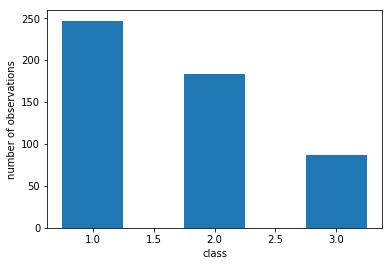

In [23]:
## doing some plots to analyse the classes 

label = np.zeros(517)
y = np.zeros(3)

# so now taking all the 13 features and then mapping them into 3 classes 
#based upon the fire in the particular area
## class 1:- No fire 
## class 2:- Low-Moderate:- (0,11)
## class 3 :- high :- greater than 11
area = original_data.iloc[:,12]
for i in range(len(area)):
    if area[i] == 0:
        label[i] = 0
        y[0] += 1
    elif  area[i] > 11:
        label[i] = 2
        y[2]+=1
    else:
        label[i] = 1
        y[1] += 1
x = np.arange(3) + 1

plt.bar(x,y,width = 0.5)
plt.xlabel("class")
plt.ylabel("number of observations")



In [26]:
# esthablishing covariance in the matrices ,
# also during observation , we found that many features are quite ecentric 
# rain field always is 0 when there is fine 99.9% of time.
# also removing the area from the dataset
data = final_data.drop(final_data.index[len(final_data) - 1])
data = data.drop(data.index[len(data) - 1])

Text(0,0.5,'Magnitude')

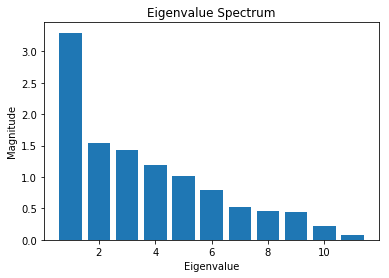

In [27]:
# now finding the eigen value spectrum  by multiplying AA^t /N
N = data.shape[1]
C =  np.dot(data,np.transpose(data))/N
# generating the eigen values
eigen_values , eigen_vectors = LA.eig(C)
c_tilde = np.diag(eigen_values)
# SORTING INTO CORRECT ORDER ANH=D THEN PLOTTING THEM
idx = eigen_values.argsort()[::-1]   
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]
x = np.arange(len(data))
plt.bar(x+1, eigen_values)
plt.title("Eigenvalue Spectrum")
plt.xlabel("Eigenvalue")
plt.ylabel("Magnitude")